In [10]:
import numpy as np
from numpy import mean,std, dstack
import pandas as pd
from pandas import read_csv
import seaborn as sns

import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, LSTM
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.utils import to_categorical

In [3]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    feature_name_df = pd.read_csv('./data/HAR/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    

    X_train = pd.read_csv('./data/HAR/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/HAR/test/X_test.txt',sep='\s+', names=feature_name)
    

    y_train = pd.read_csv('./data/HAR/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/HAR/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = get_human_dataset()

In [5]:
batch_size = 64
validation_split = 0.2

In [6]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):

        end_ix = i + n_steps

        if end_ix > len(sequences):
            break

        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

X_train, y_train = split_sequences(train_set, 30)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 30)
print(X_test.shape, y_test.shape)

(7323, 30, 561) (7323,)
(2918, 30, 561) (2918,)


In [8]:
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(7323, 7)
(2918, 7)


In [11]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
train_epochs = 20
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 16s 86ms/step - loss: 1.1025 - accuracy: 0.5615 - val_loss: 0.5823 - val_accuracy: 0.7795
Epoch 2/20
92/92 [==============================] - 6s 68ms/step - loss: 0.5236 - accuracy: 0.8068 - val_loss: 0.3738 - val_accuracy: 0.8621
Epoch 3/20
92/92 [==============================] - 7s 73ms/step - loss: 0.3538 - accuracy: 0.8749 - val_loss: 0.3136 - val_accuracy: 0.8819
Epoch 4/20
92/92 [==============================] - 7s 73ms/step - loss: 0.2607 - accuracy: 0.9090 - val_loss: 0.2201 - val_accuracy: 0.9126
Epoch 5/20
92/92 [==============================] - 6s 67ms/step - loss: 0.2003 - accuracy: 0.9312 - val_loss: 0.2340 - val_accuracy: 0.9304
Epoch 6/20
92/92 [==============================] - 6s 66ms/step - loss: 0.1723 - accuracy: 0.9379 - val_loss: 0.1952 - val_accuracy: 0.9304
Epoch 7/20
92/92 [==============================] - 7s 71ms/step - loss: 0.1516 - accuracy: 0.9469 - val_loss: 0.1595 - val_accuracy: 0.9461
Epoch 8/20
9

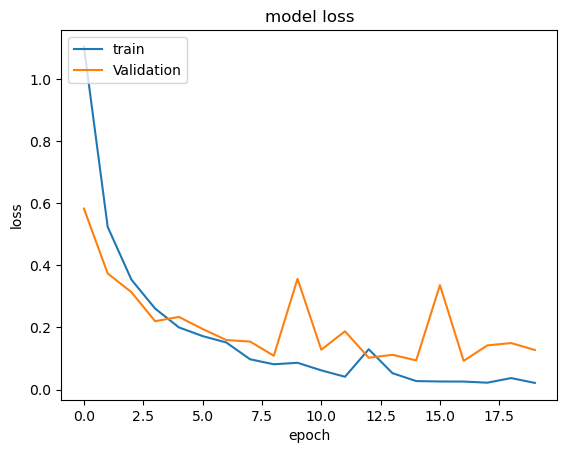

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN+LSTM model", test_accuracy)
predictions = model.predict(X_test)

Accuracy of the CNN+LSTM model 0.9599040150642395
92/92 [==============================] - 3s 15ms/step


In [16]:
predictions

array([[1.8442653e-07, 1.9304882e-06, 1.5354228e-05, ..., 4.7830720e-03,
        9.9519557e-01, 1.0461785e-06],
       [1.6091661e-07, 2.0272269e-06, 1.2679380e-05, ..., 3.6601529e-03,
        9.9632096e-01, 8.1191098e-07],
       [8.6811915e-06, 8.6773016e-06, 5.7548485e-05, ..., 6.4329481e-01,
        3.5640642e-01, 2.1539530e-04],
       ...,
       [2.9655275e-06, 1.9694083e-04, 9.3344116e-01, ..., 7.4705906e-07,
        4.3589913e-05, 7.7843415e-06],
       [2.1079545e-06, 8.8706533e-05, 9.9136972e-01, ..., 7.1606911e-07,
        5.6364712e-05, 7.1436557e-06],
       [3.4080942e-06, 9.3054725e-04, 6.3470584e-01, ..., 9.8747432e-07,
        9.3553732e-05, 6.8793279e-06]], dtype=float32)

In [17]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[490   0   6   0   0   0]
 [  0 405  66   0   0   0]
 [  1   1 418   0   0   0]
 [  0   0   0 464  22   5]
 [  0   1   0  12 490   0]
 [  0   0   0   3   0 534]]
**** Classification Report ****
              precision    recall  f1-score   support

     Walking       1.00      0.99      0.99       496
      Walkup       1.00      0.86      0.92       471
    Walkdown       0.85      1.00      0.92       420
     Sitting       0.97      0.95      0.96       491
    Standing       0.96      0.97      0.97       503
      Laying       0.99      0.99      0.99       537

    accuracy                           0.96      2918
   macro avg       0.96      0.96      0.96      2918
weighted avg       0.96      0.96      0.96      2918



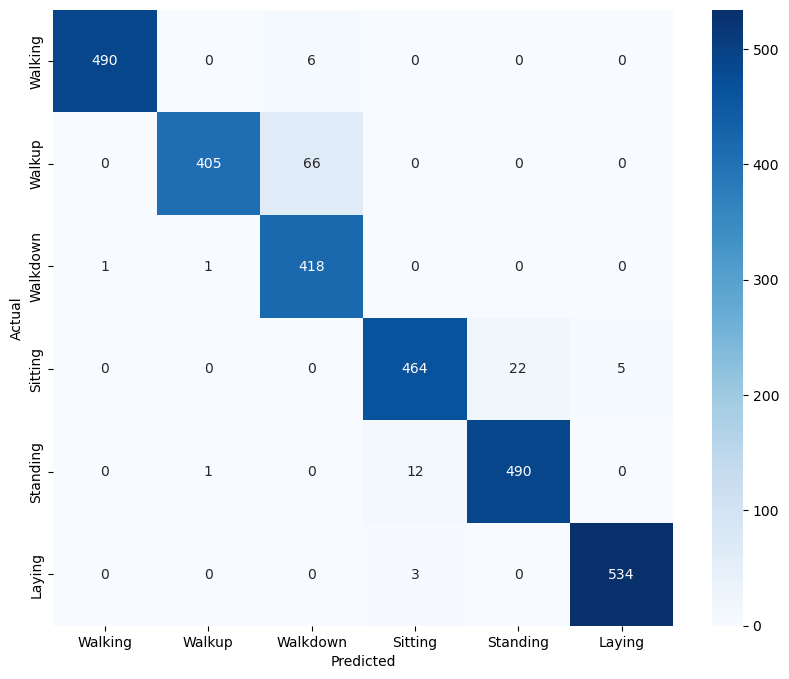

In [18]:
classNames=["Walking","Walkup","Walkdown","Sitting","Standing","Laying"]
display_results(y_test,predictions,classNames)